In [46]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_checkerboard,make_circles,make_moons,make_s_curve,make_swiss_roll
from helper_plot import hdr_plot_style
import torch
from utils import * 
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
%matplotlib inline


In [34]:
def calculate_hellinger(p_recon,p_orig):
    rootdifference = (np.sqrt(p_recon)-np.sqrt(p_orig))**2
    return 1/np.sqrt(2) * np.sqrt(np.sum(rootdifference))

In [35]:
def center_moon(data):
    means = np.mean(data,axis=0)
    xmean = means[0]
    ymean = means[1]
    data = data - np.mean(data,axis=0)
    return data, xmean, ymean

def uncenter_moon(data, xmean, ymean):
    data[:,0] = data[:,0] + xmean
    data[:,1] = data[:,1] + ymean
    return data

def rotate_data(data,radian):
    rotational_matrix = np.array([[np.cos(radian),-np.sin(radian)],[np.sin(radian),np.cos(radian)]])
    return (np.matmul(rotational_matrix, data.T)).T

def make_ood(numood,radian):
    standardmoon,_ = make_moons(numood, noise=0.1)
    ood, xmean, ymean = center_moon(standardmoon)
    ood = rotate_data(ood, radian)
    ood = uncenter_moon(ood, xmean, ymean)
    return ood

In [42]:
def mix_samples(target, num_target, mnratio,radian):

    #assign target and ood sample size with given mnratio
    numood = int(num_target * mnratio)
    if (mnratio<0):
        print("mnratio must be nonnegative")
        return 0


    if (numood!=0):
        oodset = make_ood(numood, radian)
        return np.append(target, oodset, axis=0)
    else:
        return target        


In [37]:
#generate training data for the diffusion model. Each has 10000 samples, but different m/n ratio. OOD sample is rotated 90 degrees.

#data is of shape 10000*2
numtarget = 1000
newmoon,_ = make_moons(numtarget, noise=0.1)
target = newmoon

#make ood set
ood = make_ood(4000, -np.pi/4)

#make target p
x_binedge = np.linspace(-2.5,3.5,31)
y_binedge = np.linspace(-2.5,3.5,31)
h_orig,xbin2,ybin2,img = plt.hist2d(target[:,0],target[:,1], bins=[x_binedge,y_binedge])
p_orig = h_orig/numtarget


Using matplotlib backend: <object object at 0x000001A17822D520>


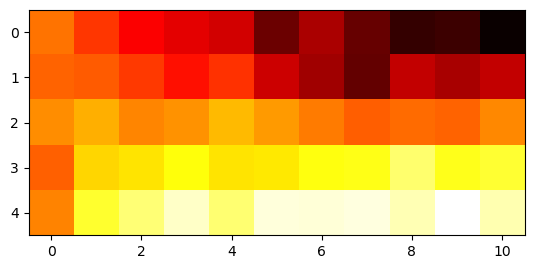

In [66]:
import csv
with open('angledistance.csv') as fd:
    reader=csv.reader(fd, delimiter=' ')
    interestingrows= np.array([row for idx, row in enumerate(reader) if idx % 2 != 0])
    interestingrows = interestingrows.astype(float)

plt.imshow(interestingrows, cmap='hot', interpolation='nearest')

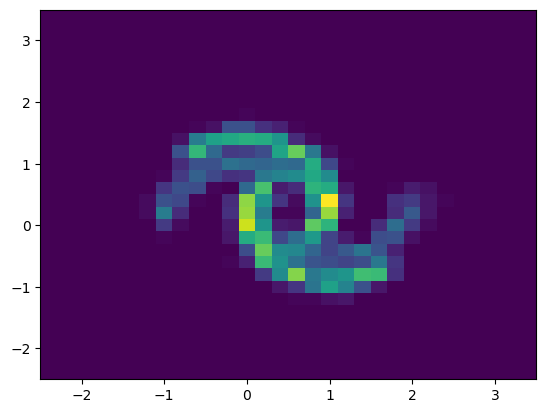

In [67]:
helling_list = []
for rad in np.linspace(0, -np.pi/4, 5):
    temp = []
    for ratio in np.linspace(0,2,11):
        targetood = mix_samples(target, 1000, ratio, rad)
        h_recon, xbin, ybin, img = plt.hist2d(targetood[:,0], targetood[:,1],bins=[x_binedge, y_binedge])
        p_recon = h_recon / targetood.shape[0]
        temp.append(calculate_hellinger(p_recon, p_orig))
    helling_list.append(temp)

Text(0.5, 1.0, '$target= moons--ood= moons.rotate(\\theta)$')

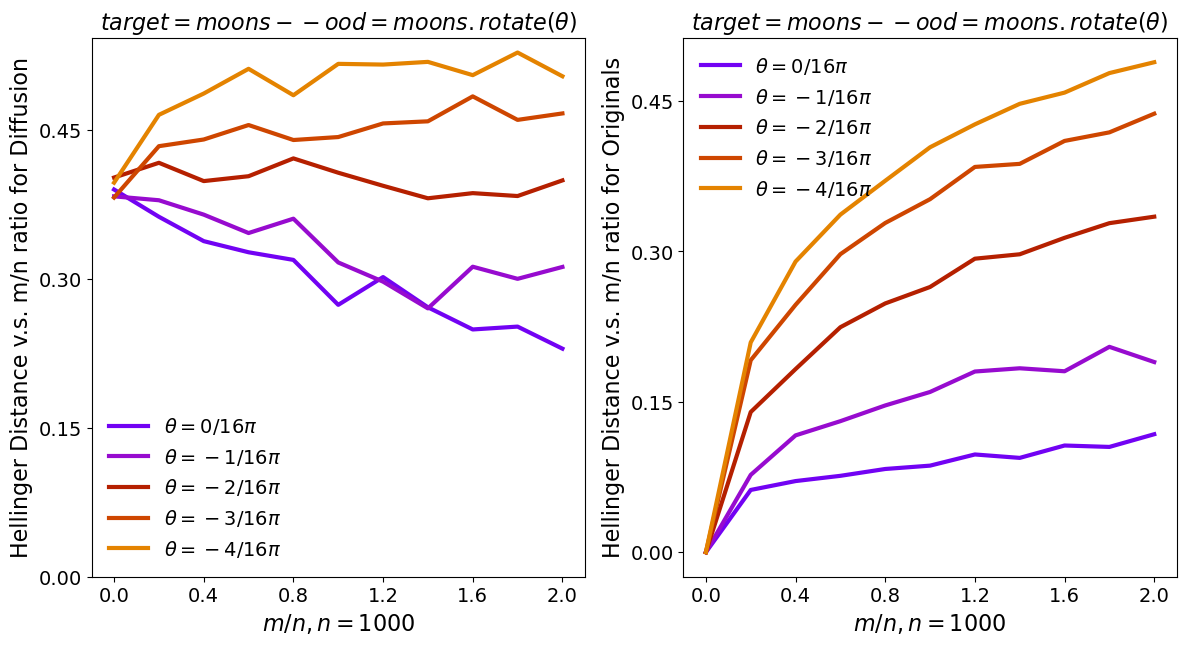

In [68]:
fontsize = 16
labelsize = 14
fig, ax = plt.subplots(1,2,figsize=(14, 7))
cmap = [plt.cm.gnuplot(i) for i in np.linspace(0.2, 0.8, len(interestingrows))]
for i in range(len(interestingrows)):
    ax[0].plot(np.linspace(0,2,11), interestingrows[i],c=cmap[i], lw=3, label= r"$ \theta= {x}/{yp}$".format(x=-i, yp=16)+r"$\pi$")
ax[0].set_ylabel("Hellinger Distance v.s. m/n ratio for Diffusion", fontsize=fontsize)
ax[0].set_xlabel(r"$m/n, n=1000$", fontsize=fontsize)
ax[0].set_xticks(np.linspace(0,2,10))
ax[0].set_yticks(np.linspace(0,0.5,10))
ax[0].tick_params(axis='x', labelsize=labelsize)
ax[0].tick_params(axis='y', labelsize=labelsize)
ax[0].legend(fontsize=labelsize, frameon=False)
ax[0].xaxis.set_major_locator(MaxNLocator(6))
ax[0].yaxis.set_major_locator(MaxNLocator(5))
ax[0].set_title(r"$target= moons--ood= moons.rotate(\theta)$", fontsize=fontsize)
for i in range(len(helling_list)):
    ax[1].plot(np.linspace(0,2,11), helling_list[i],c=cmap[i], lw=3, label=r"$ \theta= {x}/{yp}$".format(x=-i, yp=16)+r"$\pi$")
ax[1].set_ylabel("Hellinger Distance v.s. m/n ratio for Originals", fontsize=fontsize)
ax[1].set_xlabel(r"$m/n, n=1000$", fontsize=fontsize)
ax[1].set_xticks(np.linspace(0,2,10))
ax[1].set_yticks(np.linspace(0,0.5,10))
ax[1].tick_params(axis='x', labelsize=labelsize)
ax[1].tick_params(axis='y', labelsize=labelsize)
ax[1].legend(fontsize=labelsize, frameon=False)
ax[1].xaxis.set_major_locator(MaxNLocator(6))
ax[1].yaxis.set_major_locator(MaxNLocator(5))
ax[1].set_title(r"$target= moons--ood= moons.rotate(\theta)$", fontsize=fontsize)


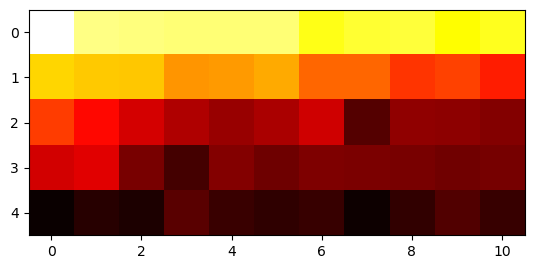

In [69]:
with open('reviseddistance.csv') as fd:
    reader=csv.reader(fd, delimiter=' ')
    interestingrows2= np.array([row for idx, row in enumerate(reader) if idx % 2 != 0])
    interestingrows2 = interestingrows2.astype(float)

plt.imshow(interestingrows2, cmap='hot', interpolation='nearest')

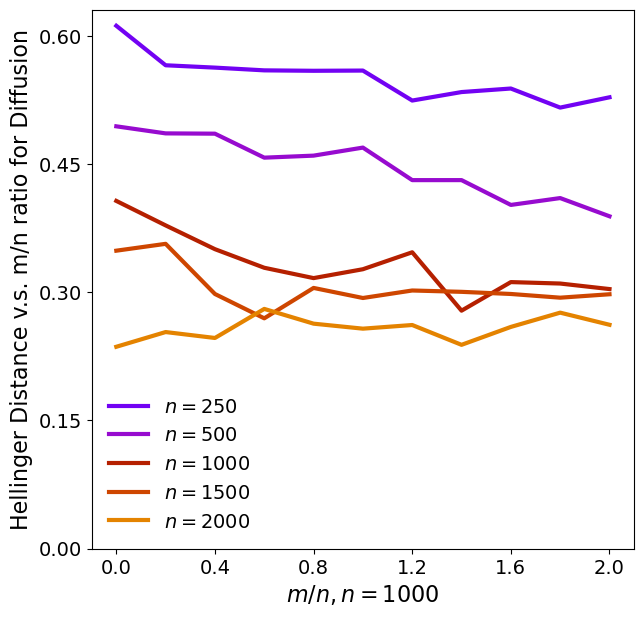

In [71]:
fontsize = 16
labelsize = 14
sets = [250,500,1000,1500,2000]
fig, ax = plt.subplots(figsize=(7, 7))
cmap = [plt.cm.gnuplot(i) for i in np.linspace(0.2, 0.8, len(interestingrows2))]
for i in range(len(interestingrows2)):
    ax.plot(np.linspace(0,2,11), interestingrows2[i],c=cmap[i], lw=3, label= r"$n = {x}$".format(x=sets[i]))
ax.set_ylabel("Hellinger Distance v.s. m/n ratio for Diffusion", fontsize=fontsize)
ax.set_xlabel(r"$m/n, \theta = -\pi$", fontsize=fontsize)
ax.set_xticks(np.linspace(0,2,10))
ax.set_yticks(np.linspace(0,0.5,10))
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
ax.legend(fontsize=labelsize, frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(6))
ax.yaxis.set_major_locator(MaxNLocator(5))